# Lesson 6: Planning and Stock Report Generation

- We will create Multi Agent Group chat and build customer group chat that collaborates to generate the detail report and stock performance over past few months .
- We will include planner agent in group chat. We will also learn how to customize the speakers transition into group chat

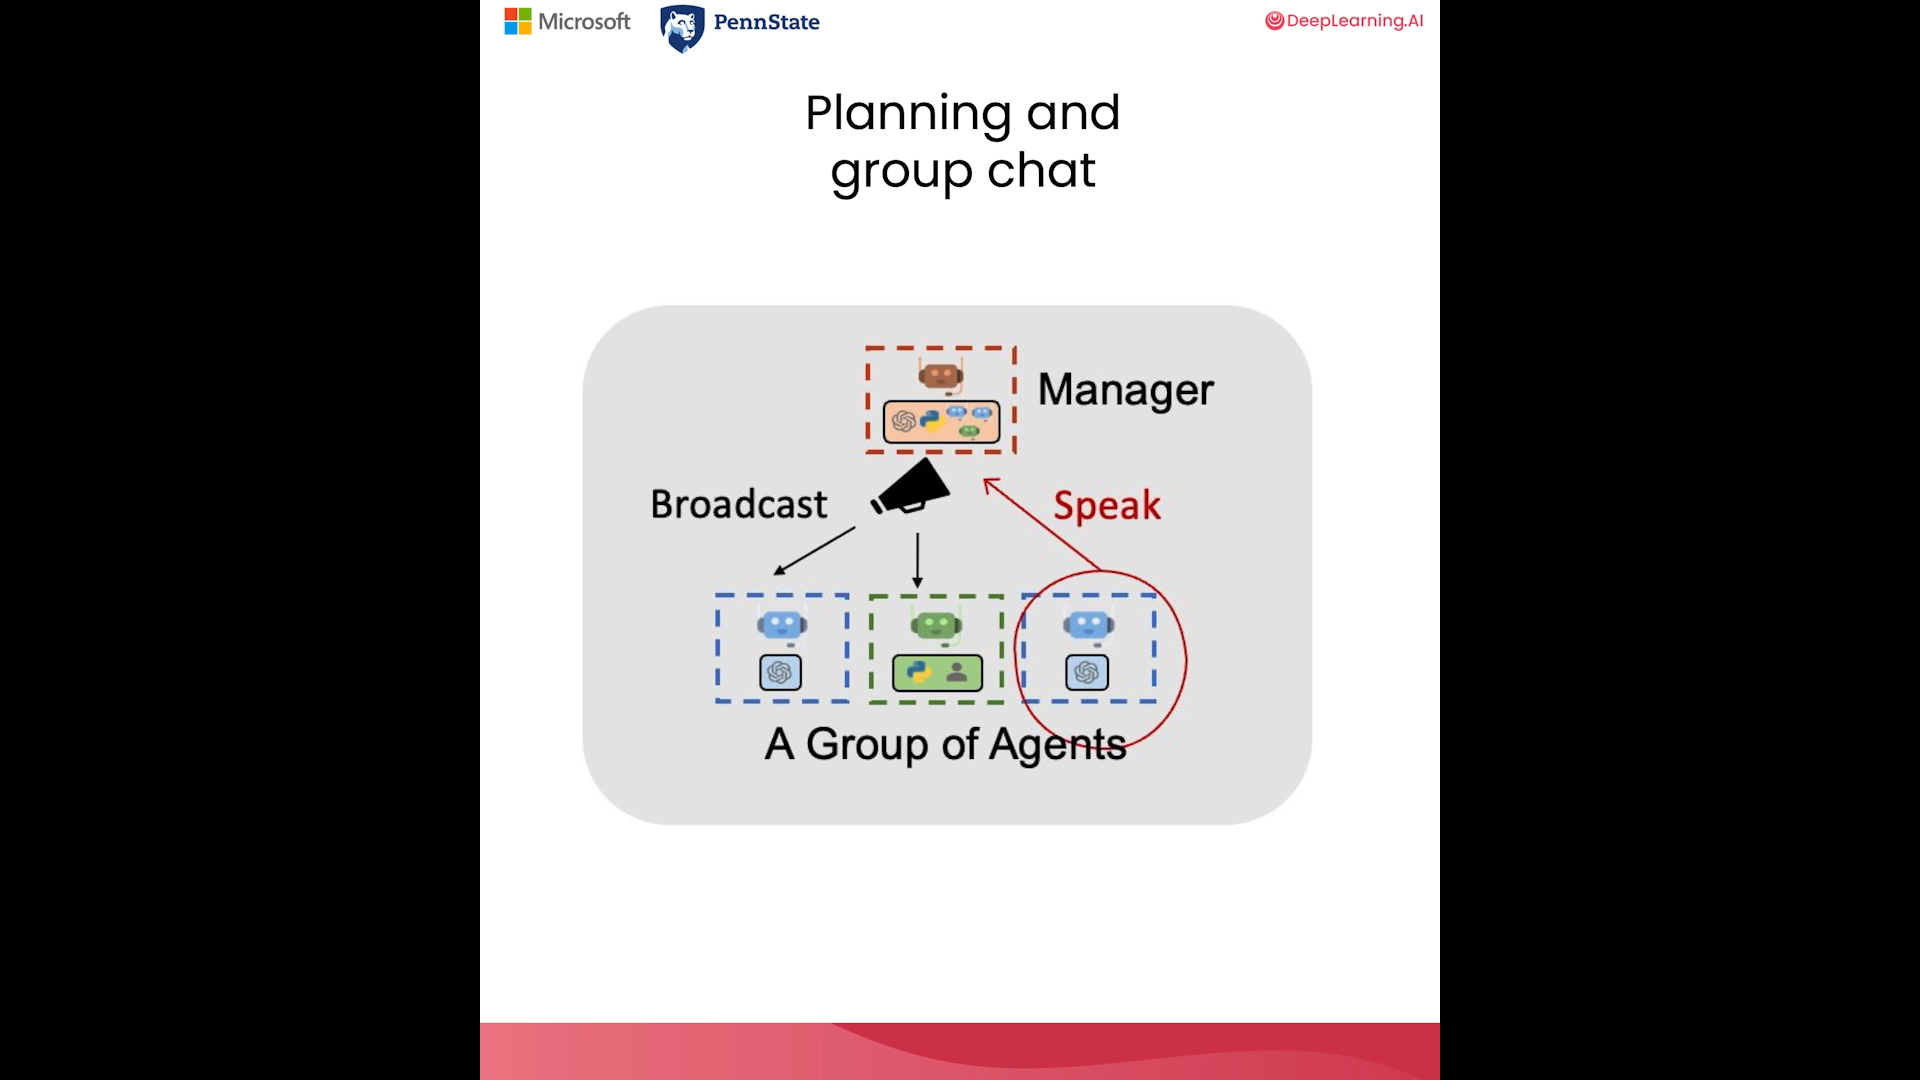

## Setup

In [1]:
llm_config={"model": "gpt-4-turbo"}

## The task!

In [4]:
task = "Write a blogpost about the stock price performance of "\
"Nvidia in the past month. Today's date is 2024-07-25."

## Build a group chat

This group chat will include these agents:

1. **User_proxy** or **Admin**: to allow the user to comment on the report and ask the writer to refine it.
2. **Planner**: to determine relevant information needed to complete the task.
3. **Engineer**: to write code using the defined plan by the planner.
4. **Executor**: to execute the code written by the engineer.
5. **Writer**: to write the report.

In [3]:
import autogen

In [5]:
user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="ALWAYS",
)

In [8]:
planner = autogen.ConversableAgent(
    name="Planner",
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    
    ## Description will help other agents to know that what this agent role is 
    description="Planner. Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)

In [10]:
engineer = autogen.AssistantAgent(
    name="Engineer",
    ## We are using default system message for this agent
    llm_config=llm_config,
    description="An engineer that writes code based on the plan "
    "provided by the planner.",
)

**Note**: In this lesson, you'll use an alternative method of code execution by providing a dict config. However, you can always use the LocalCommandLineCodeExecutor if you prefer. For more details about code_execution_config, check this: https://microsoft.github.io/autogen/docs/reference/agentchat/conversable_agent/#__init__

In [11]:
executor = autogen.ConversableAgent(
    name="Executor",
    system_message="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "coding",
        "use_docker": False,
    },
)

In [12]:
writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer."
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="Writer."
    "Write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog."
)

## Define the group chat

In [13]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],
    max_round=10,
)

In [14]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, llm_config=llm_config
)


## Start the group chat!

<p style="background-color:#ECECEC; padding:15px; "> <b>Note:</b> In this lesson, you will use GPT 4 for better results. Please note that the lesson has a quota limit. If you want to explore the code in this lesson further, we recommend trying it locally with your own API key.

In [15]:
groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)
### Chat manager will whom should we give chance to speak based on the roles of agents and conversation history

Admin (to chat_manager):

Write a blogpost about the stock price performance of Nvidia in the past month. Today's date is 2024-07-25.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Planner (to chat_manager):

To write a blog post about Nvidia's stock price performance over the past month, you will need the following information which can be retrieved using Python:

1. **Historical Stock Prices of Nvidia for the Past Month**:
   - Daily closing prices
   - Daily high and low prices
   - Volume of stocks traded daily
   - Any significant spikes or drops in price
   - Calculations of percentage growth or decline during this month

2. **Potential Factors Influencing Stock Prices**:
   - Recent news or announcements from Nvidia, such as product releases or financial disclosures
   - General market conditions affecting tech stocks or broader indices during this period
   - Analyst reports or ratings changes, if any

3. **Compar


--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Writer (to chat_manager):

```md
# In-Depth Analysis of Nvidia's Stock Performance Over the Past Month

## Introduction
Nvidia, a pivotal player in the graphics processing unit (GPU) market, has experienced notable volatility over the past month. As a bellwether for the tech industry, Nvidia's stock movements reflect broader market dynamics as well as company-specific developments. This report delves into Nvidia’s trading dynamics from June 25, 2024, to July 24, 2024, setting the stage with an understanding of the currents affecting tech stocks globally.

## Detailed Stock Price Movements
- **Opening at $126.09** on June 25, Nvidia's stock demonstrated significant fluctuations, reflecting investor reactions to industry events and news:
   - **Peak:** The stock reached its highest at $135.10 on July 10, likely boosted by optimistic market news or positive earnings expectations


--------------------------------------------------------------------------------
Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: exit


Now if we review the conversation , We will find that planner does play the role of suggesting initial plan . And after some steps finished .It will review the progress and follow the other steps. But not all the steps are followed exactly . After first 2 steps writer skip third step and directy started writting blog post.

To avoid this we can set contraints for speaker order


## Add a speaker selection policy

In [16]:
user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="ALWAYS",
)

planner = autogen.ConversableAgent(
    name="Planner",
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    description="Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)

engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    description="Write code based on the plan "
    "provided by the planner.",
)

writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer. "
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="After all the info is available, "
    "write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog. ",
)

executor = autogen.ConversableAgent(
    name="Executor",
    description="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "coding",
        "use_docker": False,
    },
)

In [17]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],
    max_round=10,
    allowed_or_disallowed_speaker_transitions={
        
        ### Which agent is allowed to speak after this agent
        user_proxy: [engineer, writer, executor, planner],
        engineer: [user_proxy, executor],
        writer: [user_proxy, planner],
        executor: [user_proxy, engineer, planner],
        planner: [user_proxy, engineer, writer],
    },
    speaker_transitions_type="allowed",
)

In [ ]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, llm_config=llm_config
)

groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)

**Note**: You might experience slightly different interactions between the agents. The engineer agent may write incorrect code, which the executor agent will report and send back for correction. This process could go through multiple rounds.